# Crash Course to Forecasting with Neural Networks

## Methods/Concepts: Transforms, PCA, Lasso, and LSTMs


**Prepared by:** Harrison Ward

**Date: 04-10-23** 

Send corrections and suggestions to hward4116@gmail.com


In this notebook we will walk through a brief example of how we could conduct forecasting with state of the art neural network models called LSTMs. These models were originally developed to work with language data to draw relationships betweens words throughout a sentence but because they can "remember" what happened in a data series and use that information to inform their guesses about the future, they are also quite useful for time-series forecasts. 

Credits and Addtional resources:
- Jason Brownlee's article: "How to Develop LSTM Models for Time Series Forecasting" is a comprehensive introduction to applying LSTMs and his code for creating test and train sets is used in my code below

- The data used in this example is sourced from FRED and fetched with the fredapi package

In [43]:
# import packages
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
from fredapi import Fred
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Our Inflation Series

There are a number of inflation related series we could go with, and for this exercise I will mainly focus on CPI for All Urban Consumers 

Description of Consumer Price Index for All Urban Consumers: All Items in U.S. City Average from FRED

Here is the full description of the data from FRED:

"The Consumer Price Index for All Urban Consumers: All Items (CPIAUCSL) is a price index of a basket of goods and services paid by urban consumers. Percent changes in the price index measure the inflation rate between any two time periods. The most common inflation metric is the percent change from one year ago. It can also represent the buying habits of urban consumers. This particular index includes roughly 88 percent of the total population, accounting for wage earners, clerical workers, technical workers, self-employed, short-term workers, unemployed, retirees, and those not in the labor force.

The CPIs are based on prices for food, clothing, shelter, and fuels; transportation fares; service fees (e.g., water and sewer service); and sales taxes. Prices are collected monthly from about 4,000 housing units and approximately 26,000 retail establishments across 87 urban areas. To calculate the index, price changes are averaged with weights representing their importance in the spending of the particular group. The index measures price changes (as a percent change) from a predetermined reference date. In addition to the original unadjusted index distributed, the Bureau of Labor Statistics also releases a seasonally adjusted index. The unadjusted series reflects all factors that may influence a change in prices. However, it can be very useful to look at the seasonally adjusted CPI, which removes the effects of seasonal changes, such as weather, school year, production cycles, and holidays.

The CPI can be used to recognize periods of inflation and deflation. Significant increases in the CPI within a short time frame might indicate a period of inflation, and significant decreases in CPI within a short time frame might indicate a period of deflation. However, because the CPI includes volatile food and oil prices, it might not be a reliable measure of inflationary and deflationary periods. For a more accurate detection, the core CPI (CPILFESL) is often used. When using the CPI, please note that it is not applicable to all consumers and should not be used to determine relative living costs. Additionally, the CPI is a statistical measure vulnerable to sampling error since it is based on a sample of prices and not the complete average. "

In [2]:
# import data from fred
from secret import fred_api_key
fred = Fred(api_key=fred_api_key)

urbcore = fred.get_series('CPIAUCSL')

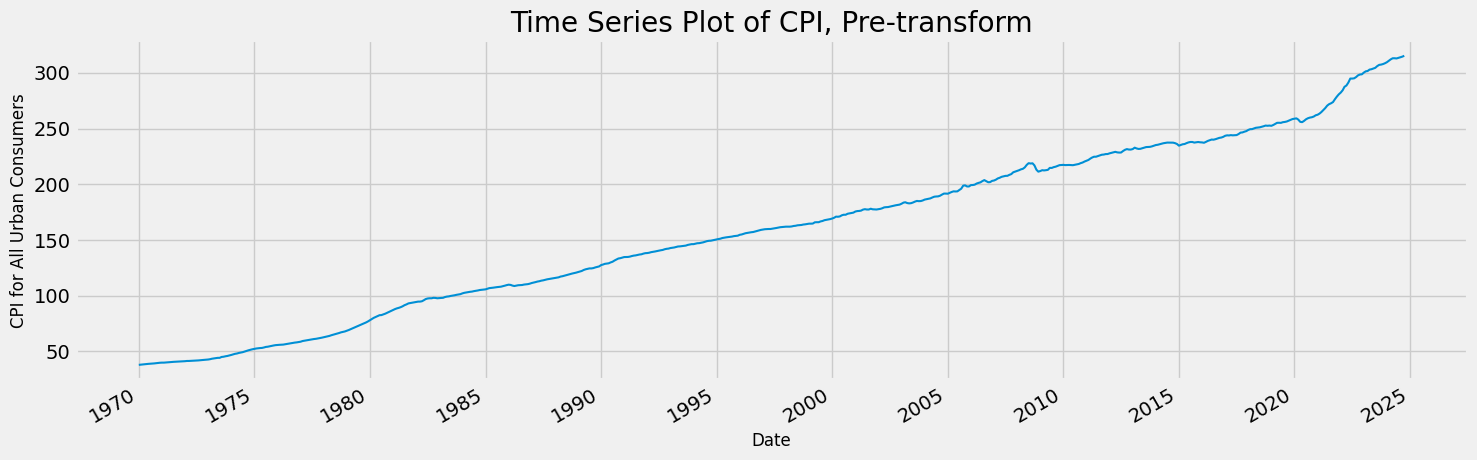

In [3]:
# take subsets of the series starting at the begining of the year 1970
uc = pd.DataFrame(urbcore[276:], columns=['x'])


year_formatter = mdates.DateFormatter("%Y")
yearly_locator = mdates.YearLocator(5)
monthly_locator = mdates.MonthLocator()

plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 1, figsize=(16,5))
fig.autofmt_xdate()
axs.plot(uc.index, uc.x, linewidth=1.5)
axs.set_title('Time Series Plot of CPI, Pre-transform')
axs.set_ylabel('CPI for All Urban Consumers', size=12)
axs.set_xlabel('Date', size=12)
axs.xaxis.set_major_locator(yearly_locator)
axs.xaxis.set_major_formatter(year_formatter)
axs.xaxis.set_minor_locator(monthly_locator)

plt.show()

When working with LSTMs we do not need to transform the data from levels to changes to get accurate predictions. That said, I still think its good practice and for the sake of consistency I will show how we can transform the data into log-differences and percentage change

In [4]:
# log transform the data, append a 0 for the first period to ensure the series are the same length
uc['ln']  = np.append(np.array([0]), 100 * np.diff(np.log(uc.x))) 

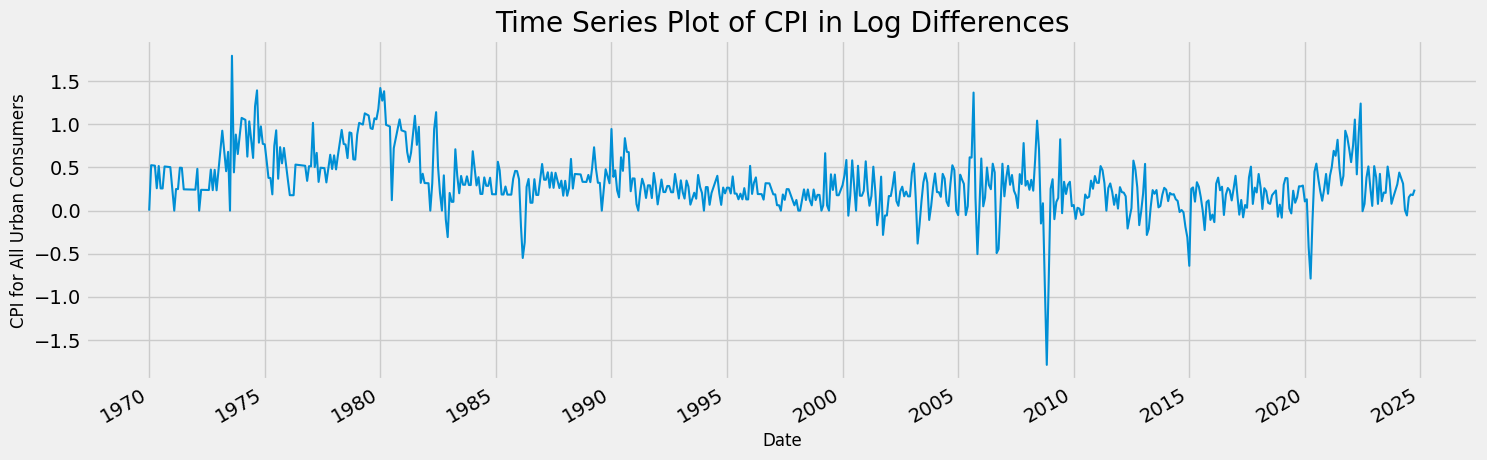

In [5]:
# plot the data post_transform 
year_formatter = mdates.DateFormatter("%Y")
yearly_locator = mdates.YearLocator(5)
monthly_locator = mdates.MonthLocator()

plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 1, figsize=(16,5))

fig.autofmt_xdate()
axs.plot(uc.index, uc.ln, linewidth=1.5)
axs.set_title('Time Series Plot of CPI in Log Differences')
axs.set_ylabel('CPI for All Urban Consumers', size=12)
axs.set_xlabel('Date', size=12)
axs.xaxis.set_major_locator(yearly_locator)
axs.xaxis.set_major_formatter(year_formatter)
axs.xaxis.set_minor_locator(monthly_locator)

plt.show()

In [6]:
# percentage change transform the data, append a 0 to ensure the series are the same length
uc['pct'] = np.append(np.array([0]), np.diff(uc.x) / uc.x[:-1] * 100)

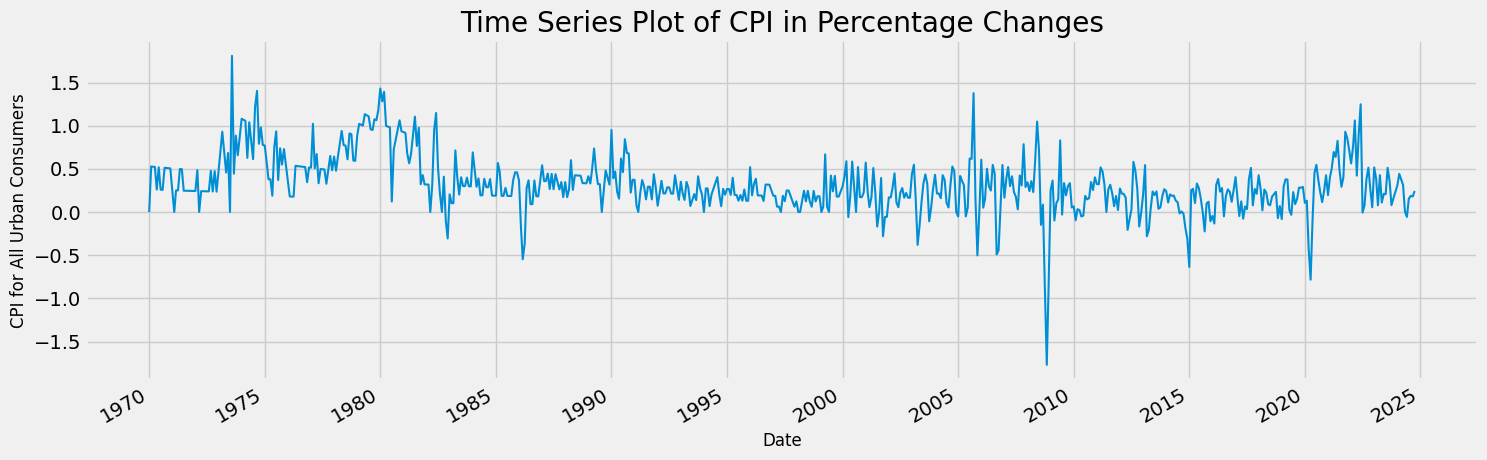

In [7]:
# plot the data post transform
year_formatter = mdates.DateFormatter("%Y")
yearly_locator = mdates.YearLocator(5)
monthly_locator = mdates.MonthLocator()

plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 1, figsize=(16,5))
fig.autofmt_xdate()
axs.plot(uc.index, uc.pct, linewidth=1.5)
axs.set_title('Time Series Plot of CPI in Percentage Changes')
axs.set_ylabel('CPI for All Urban Consumers', size=12)
axs.set_xlabel('Date', size=12)
axs.xaxis.set_major_locator(yearly_locator)
axs.xaxis.set_major_formatter(year_formatter)
axs.xaxis.set_minor_locator(monthly_locator)

plt.show()

In [8]:
# Credit to Jason Brownlee for his excellent split sequence code
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
# my modification of Jason Brownlee's function
def split_var_sequence(sequence, n_steps, n_outputs):
    X, y = list(), list()
    # step through sequence
    for i in range(len(sequence)):
        seq_index = i + n_steps
        test_index = i + n_steps + n_outputs
        # check if we are at the end of the sequence
        if seq_index > len(sequence) - 1:
            break
       # chop the sequence into train and the next N outputs
        seq_x, seq_y = sequence[i:seq_index], sequence[seq_index:test_index]
        
        # if sequence is not of full length, break; we can't pad (aka append zeros) in this context
        if len(seq_y) != n_outputs:
            break
        
        # prepare final sequences and then repeat or return
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [10]:
# reserve some data to test with
uc_train = uc[:-13]
uc_test = uc[-13:]

x_train, y_train = split_sequence(uc_train.pct, 12)
x_test, y_test = split_sequence(uc_test.pct, 12)

/var/folders/b7/9xtmcnvx6glcms00_g_hs57h0000gn/T/ipykernel_41081/2048413501.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]


In [11]:
# build our LSTM model
n_steps, n_features = 12, 1

lstm_uc_pct = keras.Sequential()

# lstm_uc_pct.add(layers.LSTM(units=32, input_shape =(n_steps, n_features)))
lstm_uc_pct.add(layers.Bidirectional(layers.LSTM(64, activation='tanh'), input_shape=(n_steps, n_features)))
lstm_uc_pct.add(layers.Dropout(0.2))
lstm_uc_pct.add(layers.Dense(1, activation='linear'))

In [12]:
# compile and fit function from Tensorflow documentation with modifcations for our use case
def compile_and_fit(model, x, y, patience=5, MAX_EPOCHS=300, verbose=1):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True,
                                                    )

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanSquaredError()])

  
  history = model.fit(x=x, y=y, epochs=MAX_EPOCHS,
                      callbacks=[early_stopping],
                      verbose=verbose)
  
  return history

In [13]:
history_uc_pct = compile_and_fit(lstm_uc_pct, x_train, y_train, patience=15, verbose=1)

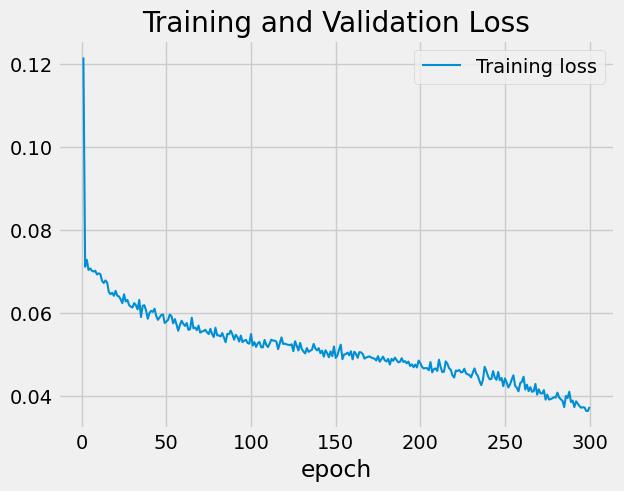

In [14]:
# plot the training data from our model 
def plot_training_history(history):
    loss = history.history['loss']
    try:
        val_loss = history.history['val_loss']
        vd = True
    except(KeyError):
        vd = False
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, linewidth=1.5, label='Training loss')
    if vd:
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

plot_training_history(history_uc_pct)

In [15]:
# generate prediction for feb 2023
pred_uc_pct = lstm_uc_pct.predict(x_test.reshape(1, n_steps, n_features))

1/1 [==============================] - 1s 1s/step


In [16]:
# append predictions to our data series for plotting
def changes_to_levels(seed_value, change_vector):
    levels_vector = []
    seed = seed_value
    for value in change_vector:
        seed = seed * (1 + value / 100)
        levels_vector.append(seed)
    
    return np.asarray(levels_vector)

x_uc_synth = np.append(uc.x[:-1], changes_to_levels(uc_test.x[-2], pred_uc_pct[0]))

/var/folders/b7/9xtmcnvx6glcms00_g_hs57h0000gn/T/ipykernel_41081/3303309469.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_uc_synth = np.append(uc.x[:-1], changes_to_levels(uc_test.x[-2], pred_uc_pct[0]))


In [17]:
def extend_index(date_index, periods):
    if not date_index.freq:
        date_index.freq = 'MS'
    new_index = date_index.union(date_index.shift(periods)[-periods:])
    
    return new_index

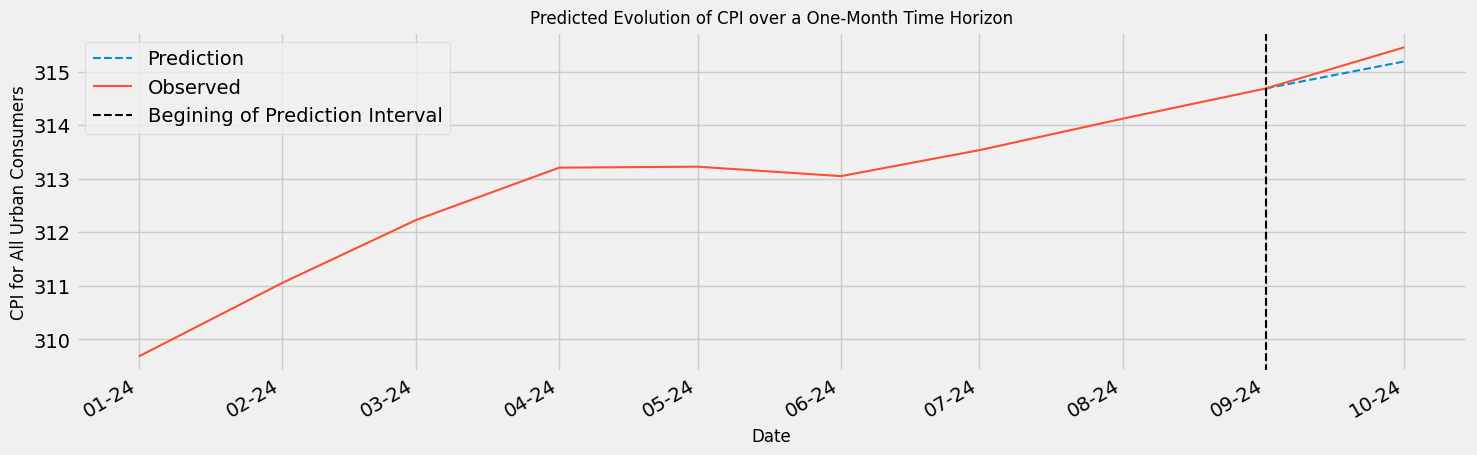

In [20]:
month_formatter = mdates.DateFormatter("%m-%y")
yearly_locator = mdates.YearLocator(1)
monthly_locator = mdates.MonthLocator()

# row one: uc_pct
fig, axs = plt.subplots(1, 1, figsize=(16,5))
fig.autofmt_xdate()
axs.plot(uc.index[-2:], x_uc_synth[-2:], linewidth=1.5, linestyle='--', label='Prediction')
axs.set_title('Predicted Evolution of CPI over a One-Month Time Horizon', fontsize=12)
axs.set_ylabel('CPI for All Urban Consumers', size=12)
axs.set_xlabel('Date', size=12)

axs.plot(uc.index[-10:], uc.x[-10:], linewidth=1.5, label='Observed')
axs.set_xlabel('Date', size=12)
axs.xaxis.set_major_locator(monthly_locator)
axs.xaxis.set_major_formatter(month_formatter)
axs.axvline(pd.to_datetime(f'2024-{9}-1'), 0, 1, linewidth=1.5, linestyle='--', color = 'black', label = 'Begining of Prediction Interval')
axs.legend();

In [41]:
# calculate the RMSE of our prediction
RMSPE = np.sum(((uc.x.iloc[-1] - x_uc_synth[-1])**2)**0.5)
print(f'Observed CPI: {uc.x.iloc[-1]:.3f}')
print(f'Predicted CPI: {x_uc_synth[-1]:.3f}')
print(f'RMSPE: {RMSPE:.3f}')

Observed CPI: 315.454
Predicted CPI: 312.241
RMSPE: 3.213


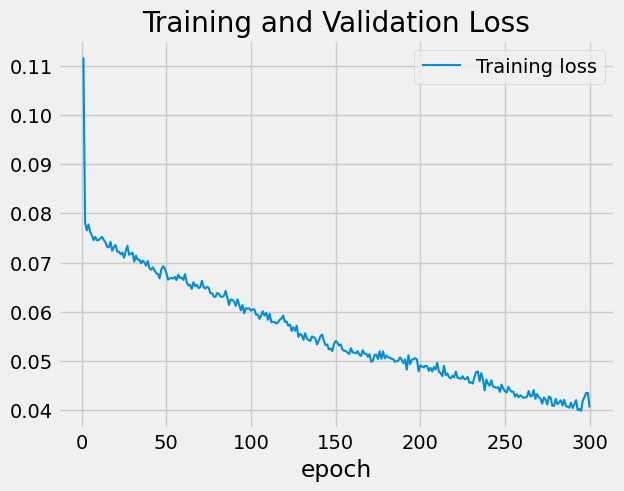

In [22]:
# refit the model to predict 4 month evolution
n_steps, n_features, n_outputs = 12, 1, 3

lstm_uc_multi = keras.Sequential()

# split my data into 12 and 3 month sequences
uc_train = uc[:-15]
uc_test = uc[-15:]

x_train, y_train = split_var_sequence(uc_train.pct, 12, 3)
x_test, y_test = split_var_sequence(uc_test.pct, 12, 3)

# lstm_uc_multi.add(layers.LSTM(units=32, input_shape =(n_steps, n_features)))
lstm_uc_multi.add(layers.Bidirectional(layers.LSTM(64, activation='tanh'), input_shape=(n_steps, n_features)))
lstm_uc_multi.add(layers.Dropout(0.2))
lstm_uc_multi.add(layers.Dense(n_outputs, activation='linear'))

history_uc_multi = compile_and_fit(lstm_uc_multi, x_train, y_train, patience=15, verbose=0)
plot_training_history(history_uc_multi)

In [42]:
multi_month_forecast = lstm_uc_multi.predict(x_test.reshape(1, n_steps, n_features))

x_uc_synth = np.append(uc.x.iloc[:-3], changes_to_levels(uc.x.iloc[-4], multi_month_forecast[0]))

1/1 [==============================] - 0s 147ms/step


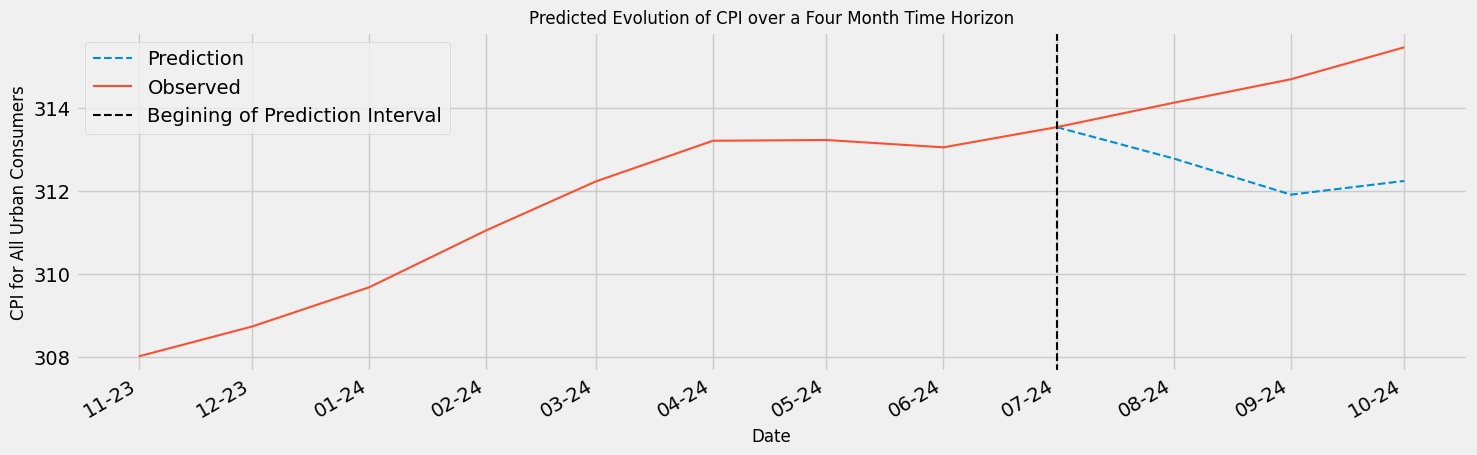

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(16,5))
fig.autofmt_xdate()
axs.plot(uc.index[-4:], x_uc_synth[-4:], linewidth=1.5, linestyle='--', label='Prediction')
axs.set_title('Predicted Evolution of CPI over a Four Month Time Horizon', fontsize=12)
axs.set_ylabel('CPI for All Urban Consumers', size=12)
axs.set_xlabel('Date', size=12)

axs.plot(uc.index[-12:], uc.x[-12:], linewidth=1.5, label='Observed')
axs.set_xlabel('Date', size=12)
axs.xaxis.set_major_locator(monthly_locator)
axs.xaxis.set_major_formatter(month_formatter)
axs.axvline(pd.to_datetime(f'2024-{7}-1'), 0, 1, linewidth=1.5, linestyle='--', color = 'black', label = 'Begining of Prediction Interval')
axs.legend();

In [32]:
# Report our Average RMSPE
obs_cpi = [f'{x:.3f}' for x in uc.x[-3:]]
pred_cpi = [f'{x:.3f}' for x in x_uc_synth[-3:]]
RMSE = ((uc.x[-3:] - x_uc_synth[-3:])**2)**0.5
RMSE_list = [f'{x:.3f}' for x in RMSE]
ARMSPE = np.average(((uc.x[-4:] - x_uc_synth[-4:])**2)**0.5)

print(f'Observed CPI: {obs_cpi}')
print(f'Predicted CPI: {pred_cpi}')
print(f'RMSPE by Month: {RMSE_list}')
print(f'Average RMSPE: {ARMSPE:.3f}')

Observed CPI: ['314.121', '314.686', '315.454']
Predicted CPI: ['312.779', '311.912', '312.241']
RMSPE by Month: ['1.342', '2.774', '3.213']
Average RMSPE: 1.832


## Adding more features to the model

So far our model has only made our forecast based on previous values of the series we are trying to predict. As we have seen in class, that likely means we aren't using all the possible information to make our forecast. One big driver of inflation recently has been oil prices but there are a huge number of other determinants that could also factor in to CPI movement. 

That said, should we just throw the whole kitchen sink at our model and let *it* figure out what is signal and what is noise? Probably not. As we have seen with lasso and ridge, regularization techniques can make a huge impact on how well our model generalizes. This is no different when working with neural networks. I will take two approaches to finding the most predictative set of covariates for our model: lasso regression and principal component analysis.  

In [33]:
# fetch more data from FRED
# when copying and pasting into python, I like to put them in one long string and split on white space to save some time
predictors = 'MICH WTISPLC APU0000709112 UNRATE PCUOMFGOMFG CUUR0000SA0R CUSR0000SAH1 FEDFUNDS PSAVERT CIVPART'.split(' ')

datasets = []
for predictor in predictors:
    datasets.append(pd.DataFrame(fred.get_series(predictor), columns=[predictor]))

In [34]:
start_dates = []
for dataset in datasets:
    start_dates.append([dataset.index[0], dataset.index[-1], dataset.columns[0]])

for start_date in start_dates:
    print(start_date)

[Timestamp('1978-01-01 00:00:00'), Timestamp('2024-09-01 00:00:00'), 'MICH']
[Timestamp('1946-01-01 00:00:00'), Timestamp('2024-10-01 00:00:00'), 'WTISPLC']
[Timestamp('1995-07-01 00:00:00'), Timestamp('2024-10-01 00:00:00'), 'APU0000709112']
[Timestamp('1948-01-01 00:00:00'), Timestamp('2024-10-01 00:00:00'), 'UNRATE']
[Timestamp('1984-12-01 00:00:00'), Timestamp('2024-10-01 00:00:00'), 'PCUOMFGOMFG']
[Timestamp('1913-01-01 00:00:00'), Timestamp('2024-10-01 00:00:00'), 'CUUR0000SA0R']
[Timestamp('1953-01-01 00:00:00'), Timestamp('2024-10-01 00:00:00'), 'CUSR0000SAH1']
[Timestamp('1954-07-01 00:00:00'), Timestamp('2024-10-01 00:00:00'), 'FEDFUNDS']
[Timestamp('1959-01-01 00:00:00'), Timestamp('2024-09-01 00:00:00'), 'PSAVERT']
[Timestamp('1948-01-01 00:00:00'), Timestamp('2024-10-01 00:00:00'), 'CIVPART']


We see that our most shortest data series only goes back to July of 1995 (1995-07-01), so for the sake of making things balanced, I am going to shift up all my dates up to 1995 and we will only use data from that point forward. This way I can train the model on the full set of data.

In [35]:
# shift the dates up to 1995
df = datasets[0]['1995-07-01':]
for data in datasets[1:]:
    df = df.join(data['1995-07-01':])

In [44]:
# scale the data and perform PCA
scaler = StandardScaler()
X_std = scaler.fit_transform(df)

pca_bli = PCA(n_components=4)
X_pca = pca_bli.fit_transform(X_std)

In [45]:
# generate month-year labels for plotting
labels = []
for date in df.index:
    m_y = str(date).split("-")
    labels.append(f'{m_y[1]}-{m_y[0]}')

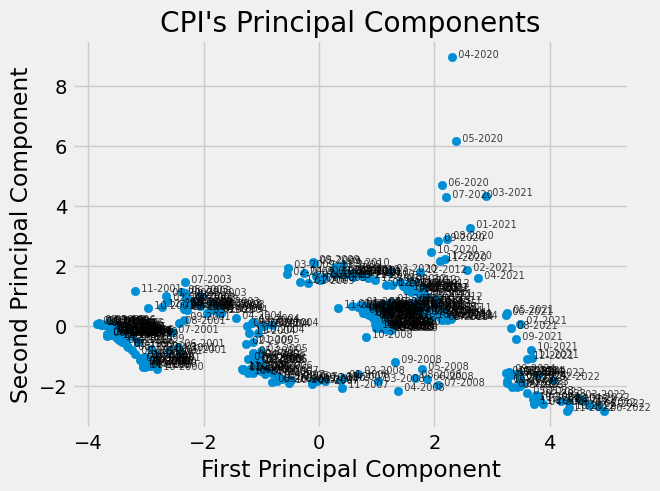

In [46]:
first_pc = X_pca[:,0]
second_pc = X_pca[:,1]
plt.scatter(first_pc, second_pc)
plt.rcParams["figure.figsize"] = (12,9)

for i, label in enumerate(labels):
    plt.annotate('  ' + label, (first_pc[i], second_pc[i]), fontsize=7, alpha=0.75)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("CPI's Principal Components")
plt.show()

What we see here is each month's CPI data projected into a lower dimensional space (called a latent space). It is important to remember that since PCA is unsupervised technique, these projections are made independent of what the CPI value (our y-value) is in that given month. 

Notice that periods of high inflation are all clumped together, with the last two years are way to the right, periods of deflation in '07 and '08 cluster near the bottom and then we have several distinct clumps of low inflationin the center of the plot.

Let's take a look at Lasso now as a point of comparision. 

In [50]:
# split cpi-numbers into X and y
y = uc['x']['1995-08-01':]
X = df.values

print(f'We can see that y and X now have the same first dimension:\ny shape: {y.shape}\nX shape: {X.shape}')

We can see that y and X now have the same first dimension:
y shape: (351,)
X shape: (351, 10)


In [51]:
reg_params = [10**(-x) for x in range(5,0, -1)]
train_error, train_std, validation_error, validation_std = [], [], [], []
folds = 10

for param in reg_params:
    lasso = Lasso(alpha=param, max_iter=250000)

    lasso.fit(X, y)

    y_pred_train = lasso.predict(X)

    mse = cross_validate(lasso, X, y, cv=folds, scoring='neg_mean_squared_error', return_train_score=True)
    
    train_error.append(-1*np.mean(mse['train_score']))
    train_std.append(np.std(mse['train_score']))

    validation_error.append(-1*np.mean(mse['test_score']))
    validation_std.append(np.std(mse['test_score']))

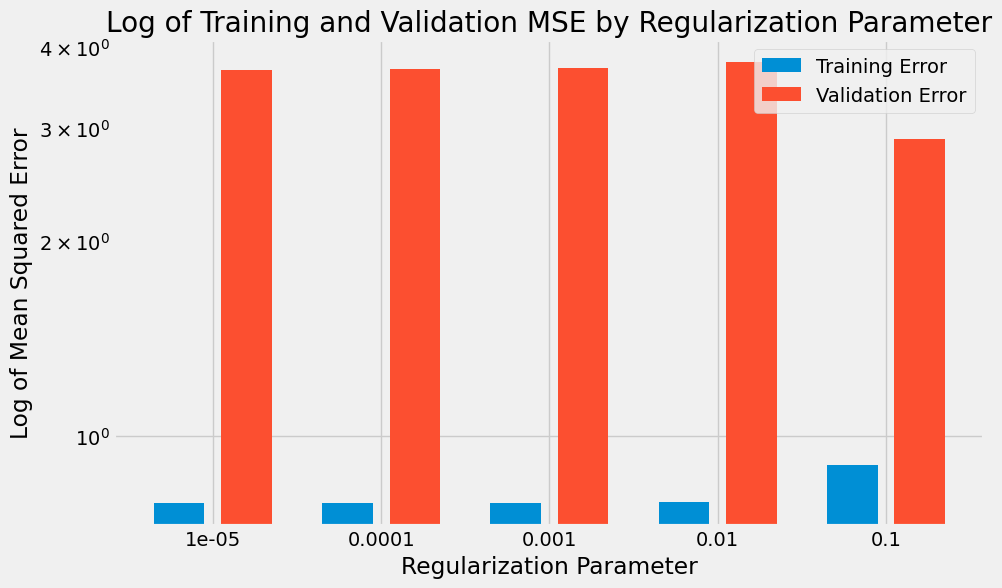

The Optimal Regularization Parameter is: 0.1
The train MSE is: 0.9004
The test MSE is: 2.8775


In [52]:
width = .3
space = .4
index = np.arange(len(reg_params))

# Plot both MSE degrees side by side
plt.rcParams["figure.figsize"] = (10,6)
plt.bar(index, train_error, width, label='Training Error', log=True)

plt.bar(index + space, validation_error, width, label='Validation Error', log=True)

# Label and annotate 
plt.title('Log of Training and Validation MSE by Regularization Parameter')
plt.xlabel('Regularization Parameter')
plt.xticks((index + space / 2), reg_params)
plt.ylabel('Log of Mean Squared Error')
plt.legend()
plt.show()

best_mse = min(validation_error)
best_param = reg_params[validation_error.index(best_mse)]

print(f'The Optimal Regularization Parameter is: {best_param}')
print(f'The train MSE is: {train_error[validation_error.index(best_mse)]:.4f}')
print(f'The test MSE is: {best_mse:.4f}')

In [53]:
lasso = Lasso(alpha=best_param, max_iter=300000)

lasso.fit(X, y)

variables = list(df.columns)
coefficients = list(lasso.coef_)

# sort the coefficients by magnitude
coefficients = sorted(coefficients, key = lambda x:abs(x), reverse=True)

print('Coefficients on Inflation Predictors by Magnitude:')
for i, coeff in enumerate(coefficients):
    print(f'{variables[i]}: {coeff:.5f}')

Coefficients on Inflation Predictors by Magnitude:
MICH: -0.69568
WTISPLC: 0.38593
APU0000709112: 0.37255
UNRATE: -0.20054
PCUOMFGOMFG: 0.16341
CUUR0000SA0R: -0.10650
CUSR0000SAH1: -0.01351
FEDFUNDS: -0.00000
PSAVERT: 0.00000
CIVPART: -0.00000


It looks like we have at least 4 variables that are significantly correlated with the CPI in that period. We can use these variables to train a new model to make our CPI forecast and hopefully improve its accuracy